# Main
This script demonstrates how the whole pipeline should work.

In [1]:
# Imports
import sys
sys.path.append('../..')

import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from help_project.src.disease_model import data
from help_project.src.disease_model import ensemble_model
from help_project.src.disease_model.models import parameter_mapper
from help_project.src.disease_model.models import sir
from help_project.src.disease_model.models import seir
from help_project.src.disease_model.utils import data_fetcher
from help_project.src.exitstrategies import data_elt
from help_project.src.exitstrategies import interface as strategy
from help_project.src.exitstrategies import lockdown_policy
from help_project.src.economic_model.models import basic_lockdown_model as economy
from help_project.src.optimization import lockdown_config
from help_project.src.optimization import loss_function
from help_project.src.optimization import optimizer
from help_project.src.optimization import visualization

In [2]:
start = datetime.date(2020, 5, 24)
end = datetime.date(2020, 6, 10)

print('Working between %s and %s' % (start, end))

Working between 2020-05-24 and 2020-06-10


In [3]:
country_policies = {'India': '1_ind'}

In [4]:
fetcher = data_fetcher.DataFetcher()
population_data = {}
past_health_data = {}
future_health_data = {}
lockdown_data = {}

# Get all distinct policies used by any country at any point
exit_strategies = strategy.ExitStrategies()
strategies = exit_strategies.strategies
all_possible_strategies = exit_strategies.all_possible_strategies

for country, strategy_id in country_policies.items():
    population_data[country] = fetcher.get_population_data(country)
    health_data = fetcher.get_health_data(country)

    past_health_data[country] = health_data[:start - datetime.timedelta(1)]
    future_health_data[country] = health_data[start:]

    lockdown_data[country] = strategies[strategy_id][:start]

In [5]:
# Generate lockdown config - which chooses one of the precomputed policies
def generate_lockdown_policy(kwargs):
    policy = all_possible_strategies[kwargs['policy']]
    policy_ts = lockdown_policy.LockdownTimeSeries([
        lockdown_policy.LockdownPolicyApplication(
            policy=policy,
            start=start,
            end=end + datetime.timedelta(1))
    ])
    return policy_ts

lockdown_config.LockdownConfig.generate_lockdown_policy = generate_lockdown_policy
config = lockdown_config.LockdownConfig(
    policy=lockdown_config.Options([i for i, _ in enumerate(all_possible_strategies)]),
)

In [6]:
# Define health & econ model wrappers and the loss function
class HealthModelWrapper:
    def __init__(self, model, population_data, health_data):
        self.model = model
        self.population_data = population_data
        self.health_data = health_data

    def run(self, policy):
        return self.model.predict(self.population_data,
                                  self.health_data,
                                  policy)

In [7]:
# Create and fit a health model per country
health_model = {}

for country in country_policies:
    model = seir.SEIR()
    model.fit(population_data[country],
              past_health_data[country],
              lockdown_data[country])
    health_model[country] = HealthModelWrapper(
        model, population_data[country], past_health_data[country])

In [8]:
pm = parameter_mapper.ParameterMapper()
pm.fit([h.model for h in health_model.values()])
for country in country_policies:
    health_model[country].model.parameter_mapper = pm

In [9]:
# Create an economic model -- TODO(Make these work differently)
economic_model = {}
for country in country_policies:
    economic_model[country] = economy.EconomicLockdownModel(country)

In [10]:
# Select a country to optimize
country = 'India'

In [11]:
# Optimize and obtain the best result
opt = optimizer.ExhaustiveSearch(config, loss_function.ParetoLoss())
results = opt.optimize(population_data, health_model[country], economic_model[country])

def describe_policy(policy):
    for country_key, policy_timeseries in strategies.items():
        for pol in policy_timeseries.policies:
            if pol.policy == policy:
                return 'Policy "%s" applied from %s to %s' % (country_key, pol.start, pol.end or 'now')
    return 'Not found'

for result in results:
    print('Deaths: %i, GDP: %.2f - %s' % (result.loss[0], -result.loss[1], describe_policy(result.solution.policies[0].policy)))

Deaths: 181057, GDP: 63392.75 - Policy "1_ind" applied from 2020-05-18 to now
Deaths: 275449, GDP: 101099.54 - Policy "1_ind" applied from 2020-02-29 to 2020-03-25


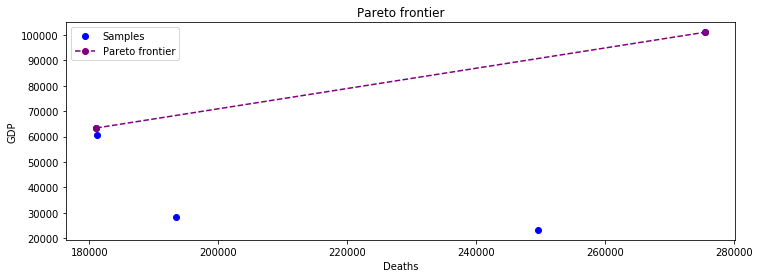

In [12]:
ax = visualization.Visualization.plot('Pareto frontier', 'Deaths', 'GDP')
visualization.Visualization.plot_samples(opt.results)
visualization.Visualization.pareto(results)
_ = plt.legend(['Samples', 'Pareto frontier'])

Wellby optimum:
--------------------
Policy "1_ind" applied from 2020-05-18 to now
181057 Deaths, GDP: 63392


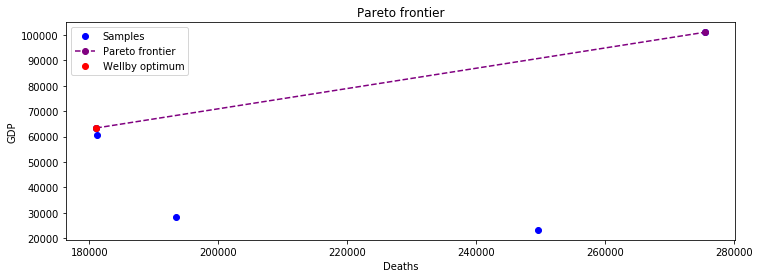

In [13]:
wellby = loss_function.WellbeingYears()
wellby_values = np.zeros(len(results))

# Re-run models to retrieve wellby values instead
for i, result in enumerate(results):
    health_output = health_model[country].run(result.solution)
    economic_output = economic_model[country].get_economic_vector(result.solution)
    wellby_values[i] = -wellby.compute(population_data[country], health_output, economic_output)

argmax = np.argmax(wellby_values)
wellby_best = results[argmax]

print('Wellby optimum:')
print('--------------------')
print(describe_policy(wellby_best.solution.policies[0].policy))
print('%i Deaths, GDP: %i' % (int(wellby_best.loss[0]), -int(wellby_best.loss[1])))

ax = visualization.Visualization.plot('Pareto frontier', 'Deaths', 'GDP')
visualization.Visualization.plot_samples(opt.results)
visualization.Visualization.pareto(results)
visualization.Visualization.plot_samples([results[argmax]], color='red')
_ = plt.legend(['Samples', 'Pareto frontier', 'Wellby optimum'])

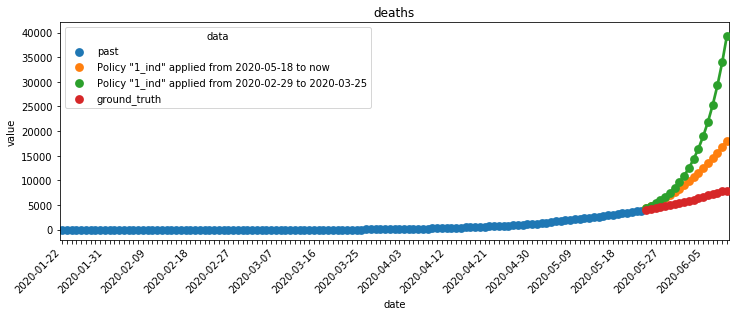

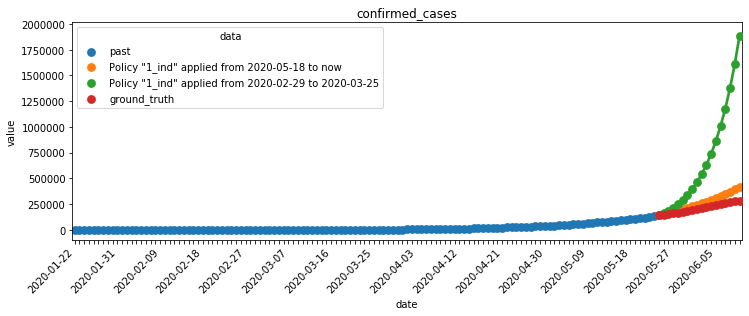

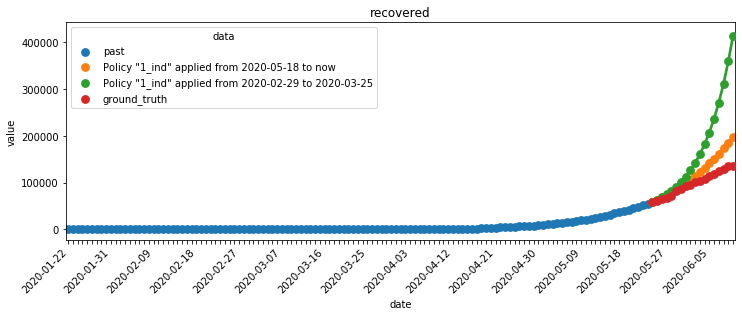

In [14]:
# Re-run pareto health models to retrieve predictions
predictions = {
    describe_policy(result.solution.policies[0].policy): health_model[country].run(result.solution)
    for result in results
}

visualization.Visualization.plot_health_timeseries(
    ['deaths', 'confirmed_cases', 'recovered'],
    past_data=past_health_data[country],
    predictions=predictions,
    ground_truth=future_health_data[country],
)